In [ ]:
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.network_builder import NetworkBuilder
from hnn_core.cell import _get_gaussian_connection
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from neurodsp.spectral import compute_spectrum, trim_spectrum
import scipy
import utils
from utils import (SingleNeuron_Data, Network_Data, CellType_Dataset_Fast,
                   linear_scale_forward, log_scale_forward, UniformPrior,
                   section_drive_param_function, ConcatTensorDataset)
import multiprocessing
import dill
from joblib import Parallel, delayed

device = torch.device("cuda:0")
# device = 'cpu'
num_cores = multiprocessing.cpu_count()
torch.backends.cudnn.enabled = True

In [ ]:
num_cores = 16


# Define simulation function
#---------------------------
def run_hnn(thetai, sample_idx, prior_dict, transform_dict=None, suffix='subthreshold', rate=20, cell_type='L5_pyramidal', save=False):

    data_path = f'/users/ntolley/scratch/bayesian_surrogates/datasets_{suffix}'

    theta_dict = {param_name: param_dict['rescale_function'](thetai[param_idx].numpy(), param_dict['bounds']) for 
                    param_idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    params = hnn_core.params_default.get_params_default()
    params.update({'N_pyr_x': 3, 'N_pyr_y': 3})
    
    net = calcium_model(params)
    if suffix != 'connected':
        net.clear_connectivity()

    theta_extra = {'cell_type_lookup': cell_type_lookup, 'valid_conn_list': list(),
                   'valid_drive_dict': dict()}
    # Connections
    for conn_idx in range(len(net.connectivity)):
        src_type = cell_type_lookup[net.connectivity[conn_idx]['src_type']]
        target_type = cell_type_lookup[net.connectivity[conn_idx]['target_type']]
        receptor = net.connectivity[conn_idx]['receptor']
        loc = net.connectivity[conn_idx]['loc']
        
        conn_name = f'{src_type}_{target_type}_{receptor}_{loc}'
        theta_extra['valid_conn_list'].append(conn_name)
        theta_extra[f'{conn_name}_conn_idx'] = conn_idx

    # Drives
    for drive_cell_type in net.cell_types.keys():
        for sec_name in net.cell_types[drive_cell_type].sections.keys():
            for syn_name in net.cell_types[drive_cell_type].sections[sec_name].syns:
                drive_name = f'{drive_cell_type}_{sec_name}_{syn_name}'
                theta_extra['valid_drive_dict'][drive_name] = {
                    'cell_type': drive_cell_type, 'location': sec_name, 'receptor': syn_name}

    theta_extra['sample_idx'] =  sample_idx
    theta_dict['theta_extra'] = theta_extra

    section_drive_param_function(net, theta_dict, rate=rate)
    dpl = simulate_dipole(net, dt=0.5, tstop=1000, record_vsec='all', record_isec='all', record_dcell=True)

    if transform_dict is None:
        input_spike_scaler, vsec_scaler, isec_scaler = None, None, None
    else:
        input_spike_scaler = transform_dict[cell_type]['input_spike_scaler']
        vsec_scaler = transform_dict[cell_type]['vsec_scaler']
        isec_scaler = transform_dict[cell_type]['isec_scaler']

    training_set = utils.CellType_Dataset_Fast(
        net, cell_type=cell_type, window_size=500, data_step_size=250,
        input_spike_scaler=input_spike_scaler, vsec_scaler=vsec_scaler, isec_scaler=isec_scaler,
        soma_filter=False, device='cpu')

    if save == True:
        torch.save(training_set, f'{data_path}/training_data/{cell_type}_dataset_online.pt')


    return training_set


In [ ]:
#LSTM/GRU architecture for decoding
class model_lstm(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim=64, n_layers=5, dropout=0.1, kernel_size=200, device='cuda:0', bidirectional=False):
        super(model_lstm, self).__init__()

        #multiplier based on bidirectional parameter
        if bidirectional:
            num_directions = 2
        else:
            num_directions = 1

        # Defining some parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers * num_directions
        self.device = device
        self.dropout = dropout
        self.bidirectional = bidirectional
        self.kernel_size = kernel_size

        self.tau1_init, self.tau2_init = 10, 20
        self.tau1 = nn.Parameter(torch.tensor(1).float().to(self.device))
        self.tau2 = nn.Parameter(torch.tensor(1).float().to(self.device))

        self.kernel_scale_init, self.kernel_offset_init = 10, -5
        self.kernel_scale = nn.Parameter(torch.tensor(1).float().to(self.device))
        self.kernel_offset = nn.Parameter(torch.tensor(1).float().to(self.device))

        # LSTM Layer
        # self.lstm = nn.LSTM(hidden_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, dropout=dropout)   

        self.fc_input = nn.Sequential(
            nn.Linear(input_size, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Tanh()
        )

        self.fc_output = nn.Sequential(
            nn.Tanh(),
            nn.Linear(hidden_dim*num_directions, self.hidden_dim),
            nn.Tanh(),
            nn.Linear(self.hidden_dim, self.hidden_dim),
            nn.Linear(self.hidden_dim, self.output_size)

        )
    
    def forward(self, x, hidden):
        batch_size = x.size(0)
        kernel = self.get_kernel(torch.arange(0, self.kernel_size, 1).to(self.device),
                                tau1=self.tau1_init, tau2=self.tau2_init).float().flip(0)
        # kernel = (kernel * self.kernel_scale * self.kernel_scale_init) + (self.kernel_offset * self.kernel_offset_init)
        kernel_product = kernel.tile(dims=(batch_size, self.input_size, 1)).transpose(1,2)

        # out = torch.log10(x+10.0)
        out = (kernel_product * x).sum(dim=1).unsqueeze(1)
        out = out - self.kernel_offset
        # print(out.shape)

        # out = self.fc_input(out.contiguous())
        out, hidden = self.lstm(out, hidden)
        out = out.contiguous()
        out = self.fc_output(out)
            
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        weight = next(self.parameters()).data.to(self.device)

        # LSTM cell initialization
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device))
    
        return hidden

    def get_kernel(self, t_vec, tau1=10, tau2=20):
        G = tau2/(tau2-tau1)*(-torch.exp(-t_vec/tau1) + torch.exp(-t_vec/tau2))
        return G

In [160]:
suffix = 'subthreshold'
rate = 20.0
net = calcium_model()

cell_type_lookup = {
    'L2_pyramidal': 'L2e', 'L2_basket': 'L2i',
    'L5_pyramidal': 'L5e', 'L5_basket': 'L5i'}


prior_dict = dict()
prior_dict['lamtha'] = {'bounds': (0, 10), 'rescale_function': linear_scale_forward}

# Connections
for conn_idx in range(len(net.connectivity)):
    src_type = cell_type_lookup[net.connectivity[conn_idx]['src_type']]
    target_type = cell_type_lookup[net.connectivity[conn_idx]['target_type']]
    receptor = net.connectivity[conn_idx]['receptor']
    loc = net.connectivity[conn_idx]['loc']
    
    conn_name = f'{src_type}_{target_type}_{receptor}_{loc}'
    
    prior_dict[f'{conn_name}_gbar'] = {'bounds': (-4, 0), 'rescale_function': log_scale_forward}
    prior_dict[f'{conn_name}_prob'] = {'bounds': (0, 1), 'rescale_function': linear_scale_forward}

# Drives
for cell_type in net.cell_types.keys():
    for sec_name in net.cell_types[cell_type].sections.keys():
        for syn_name in net.cell_types[cell_type].sections[sec_name].syns:
            drive_name = f'{cell_type}_{sec_name}_{syn_name}'
            prior_dict[f'{drive_name}_gbar'] = {'bounds': (-4, 0), 'rescale_function': log_scale_forward}
            prior_dict[f'{drive_name}_prob'] = {'bounds': (0, 1), 'rescale_function': linear_scale_forward}


prior = UniformPrior(parameters=list(prior_dict.keys()))
theta_samples = prior.sample((2,))

# First sample used to fit transformers
cell_type = 'L5_basket'

theta_samples[0,:] = torch.from_numpy(np.repeat(0.7, theta_samples.shape[1]))
dataset = run_hnn(theta_samples[0, :], 0, prior_dict, transform_dict=None, suffix=suffix, rate=rate, save=True, cell_type=cell_type)

# transform_dict = {}
# for cell_type in net.cell_types.keys():
#     dataset = torch.load(f'/users/ntolley/scratch/bayesian_surrogates/datasets_subthreshold/training_data/{cell_type}_dataset_online.pt')
#     transform_dict[cell_type] = {'input_spike_scaler': dataset.input_spike_scaler,
#                                  'vsec_scaler': dataset.vsec_scaler,
#                                  'isec_scaler': dataset.isec_scaler}
    


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Building the NEURON model
[Done]
Trial 1: 0.5 ms...
Trial 1: 10.0 ms...
Trial 1: 20.0 ms...
Trial 1: 30.0 ms...
Trial 1: 40.0 ms...
Trial 1: 50.0 ms...
Trial 1: 60.0 ms...
Trial 1: 70.0 ms...
Trial 1: 80.0 ms...
Trial 1: 90.0 ms...
Trial 1: 100.0 ms...
Trial 1: 110.0 ms...
Trial 1: 120.0 ms...
Trial 1: 130.0 ms...
Trial 1: 140.0 ms...
Trial 1: 150.0 ms...
Trial 1: 160.0 ms...
Trial 1: 170.0 ms...
Trial 1: 180.0 ms...
Trial 1: 190.0 ms...
Trial 1: 200.0 ms...
Trial 1: 210.0 ms...
Trial 1: 220.0 ms...
Trial 1: 230.0 ms...
Trial 1: 240.0 ms...
Trial 1: 250.0 ms...
Trial 1: 260.0 ms...
Trial 1: 270.0 ms...
Trial 1: 280.0 ms...
Trial 1: 290.0 ms...
Trial 1: 300.0 ms...
Trial 1: 310.0 ms...
Trial 1: 320.0 ms...
Trial 1: 330.0 ms...
Trial 1: 340.0 ms...
Trial 1: 350.0 ms...
Trial 1: 360.0 ms...
Trial 1: 370.0 ms...
Trial 1: 380.0 ms...
Trial 1: 390.0 ms...
Trial 1: 400.0 ms...
Trial 1: 410.0 ms...
Trial 1: 420.0 ms...


In [161]:
hidden_dim = 8
n_layers = 8

_, input_size = dataset[0][0].detach().cpu().numpy().shape
_, output_size = dataset[0][1].detach().cpu().numpy().shape

model = utils.model_celltype_lstm(input_size=input_size, output_size=output_size,
                                  hidden_dim=hidden_dim, n_layers=n_layers, device=device).to(device)

lr = 0.01
weight_decay = 0
max_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)


In [162]:
train_loss_array = list()
for batch_idx in range(max_epochs):
    theta_samples = prior.sample((num_cores*10,))
    dataset_list = Parallel(n_jobs=num_cores)(delayed(run_hnn)(
        thetai, sample_idx+1, prior_dict, transform_dict, suffix, rate, save=False, cell_type=cell_type) for
        (sample_idx, thetai) in enumerate(theta_samples))

    training_set = ConcatTensorDataset(dataset_list)

    #___Train model___
    model.train()
    train_batch_loss = list()
    validation_batch_loss = list()
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    batch_x = training_set[:][0].float().to(device)
    batch_y = training_set[:][1].float().to(device)

    output_sequence = list()
    h0 = torch.zeros(model.n_layers, batch_x.size(0), model.hidden_dim).to(device)
    c0 = torch.zeros(model.n_layers, batch_x.size(0), model.hidden_dim).to(device)

    for t in range(model.kernel_size, batch_x.size(1)-1):
        output, h0, c0 = model(batch_x[:,(t-model.kernel_size):t, :], h0, c0)
        output_sequence.append(output)

    output_sequence = torch.cat(output_sequence, dim=1)
    train_loss = criterion(output_sequence, batch_y[:, model.kernel_size+1:,:])

    train_loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    train_loss_array.append(train_loss.detach().cpu().numpy())

    print(f'Loss: {train_loss}')


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /oscar/home/ntolley/Jones_Lab/bayesian_surrogates/externals/hnn-core/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Loading custom mechanism files from /oscar/home/ntolley/Jones_Lab/bayesian_surrogates/externals/hnn-core/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /oscar/home/ntolley/Jones_Lab/bayesian_surrogates/externals/hnn-core/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing 

KeyboardInterrupt: 

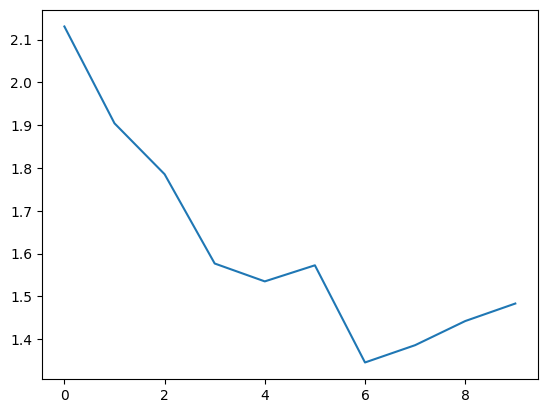

In [163]:
plt.plot(train_loss_array)

In [164]:

torch.save(model.state_dict(), f'online_models/{cell_type}_online_model.pt')
# with open(f'{dataset_type}_models/{cell_type}_{dataset_type}_loss_dict.pkl', 'wb') as f:
#     dill.dump(loss_dict, f)

In [165]:
def run_model(model, validation_set):
    val_data = validation_set[:][0][:,:,:].float().to(device)
    with torch.no_grad():
        model.eval()
        output_sequence = []
        h0 = torch.zeros(model.n_layers, 21, model.hidden_dim).to(device)
        c0 = torch.zeros(model.n_layers, 21, model.hidden_dim).to(device)
        for t in range(model.kernel_size, val_data.size(1)):
            output, h0, c0 = model(val_data[:,(t-model.kernel_size):t, :], h0, c0)
            output_sequence.append(output)

        output_sequence = torch.cat(output_sequence, dim=1)

    return output_sequence


In [174]:
validation_data = dataset_list[6]
pred = run_model(model, validation_data)

(-5.0, 405.0)

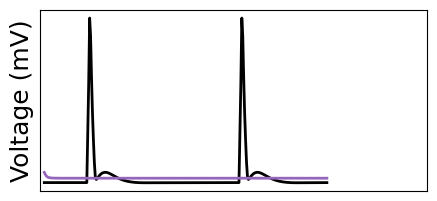

In [175]:
cell_idx = 20
hnn_color = 'k'
ann_color = 'C4'

plot_xlim = (-5,405)
linewidth = 2
fontsize=18

plt.figure(figsize=(5,8))
plt.subplot(3,1,1)
sec_idx = 0
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
plt.yticks([])
plt.ylabel('Voltage (mV)', fontsize=fontsize)
plt.xlim(plot_xlim)

# plt.savefig('single_cell_prediction.svg')


In [ ]:
# cell_idx = 4
cell_idx = 1

hnn_color = 'k'
ann_color = 'C4'

plot_xlim = (-5,405)
linewidth = 2
fontsize=18

plt.figure(figsize=(5,8))
plt.subplot(3,1,1)
sec_idx = 3
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
plt.yticks([])
plt.ylabel('Voltage (mV)', fontsize=fontsize)
plt.xlim(plot_xlim)

plt.legend(fontsize=20)

plt.subplot(3,1,2)
sec_idx = 9
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks([])
plt.yticks([])
plt.ylabel('Dipole (nAm)',fontsize=fontsize)
plt.xlim(plot_xlim)


plt.subplot(3,1,3)
sec_idx = 8
plt.plot(validation_data[cell_idx][1][200:, sec_idx].detach().cpu().numpy(), label = 'HNN', color=hnn_color, linewidth=linewidth)
plt.plot(pred[cell_idx, :, sec_idx].detach().cpu().numpy(), label = 'ANN', color=ann_color, linewidth=linewidth)
plt.xticks(size=15)
plt.yticks([])
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.ylabel('Voltage (mV)', fontsize=fontsize)
plt.xlim(plot_xlim)

# plt.savefig('single_cell_prediction.svg')
